In [1]:
import os, json

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///chinook.db")
print(db.dialect)
print(db.get_usable_table_names())


sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


## Define tools for the agent

We will define a few tools that the agent will use to interact with the database.

1. `list_tables_tool`: Fetch the available tables from the database
2. `get_schema_tool`: Fetch the DDL for a table
3. `db_query_tool`: Execute the query and fetch the results OR return an error message if the query fails

For the first two tools, we will grab them from the `SQLDatabaseToolkit`, also available in the `langchain_community` package.

In [3]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_version=os.environ["AZURE_OPENAI_API_VERSION"],   # tool_choice="required" is only supported in 2024-06-01 and later
    azure_deployment="gpt-4o",
    streaming=True,
    temperature=0
)

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

for tool in tools:
    print(tool.name)
    print(f"\t{tool.description}\n")

sql_db_query
	Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema
	Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables
	Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker
	Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [4]:
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

In [5]:
from typing import Any

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [6]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field

class GenerateQuery(BaseModel):
    """Generate a query based on the question and schema."""
    query: str = Field(..., description="The generated query to run on the sqlite3 database.")


@tool(args_schema=GenerateQuery)
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    if result.startswith("Error:"):
        return result + "\nPlease rewrite your query and try again."
    return result   # above if condition is not required as "run_no_throw returns error too"


sql_query = db_query_tool.invoke('SELECT * FROM Artist LIMIT 10;')
print(sql_query)

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


## Sqlite Async Checkpointer

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [7]:
# import sqlite3
# from langgraph.checkpoint.sqlite import SqliteSaver

# # # Transient in-memory database. This database exists only in RAM and will be lost once the connection is closed or the program terminates. 
# # conn = sqlite3.connect(":memory:", check_same_thread = False)
# # checkpointer = SqliteSaver(conn)

# # Save to local db instead of :memory: to persist state 
# db_path = "checkpointer_db/state.db"
# conn = sqlite3.connect(db_path, check_same_thread=False)
# checkpointer = SqliteSaver(conn)

In [8]:
import aiosqlite
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

db_path = "checkpointer_db/state.db"
conn = aiosqlite.connect(db_path)
checkpointer = AsyncSqliteSaver(conn)
checkpointer

# Define a Graph
## Visualize and Run the workflow

In [9]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import AzureChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages, MessagesState

# MessagesState takes care of this, so we do not need to define this
# 
# class State(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

In [10]:
# Add a node for the first tool call
def list_tables_ai_call(state: MessagesState) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

In [11]:
async def get_db_schema(state: MessagesState):  
    get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
    model_get_schema  = llm.bind_tools([get_schema_tool])
    
    messages = state["messages"]
    db_schema = await model_get_schema.ainvoke(messages)
    return {"messages": [db_schema]}

In [12]:
from langchain_core.prompts import ChatPromptTemplate
# from pydantic import BaseModel, Field

QUERY_GEN_SYSTEM_PROMPT = """You are a SQL expert with a strong attention to detail.

You have access to a SQLite database through a db_query_tool that can execute queries on the database.
Given an input question, call the tool by generating a syntactically correct SQLite query without wrapping it in any sql or markers by using "GenerateQuery" tool schema definition.
If the query fails, you will be prompted to rewrite the query and try again. 
If the query is correct, you will get the result of the query, which you can then use to answer the question.

When extracting the query argument for the tool, follow the following INSTRUCTIONS:

- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 50 results.
- ALWAYS ORDER the results by a relevant column to return the most interesting examples in the database, preferrably in descending order of numeric values using DESC.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, you will be prompted to rewrite the query and try again.
- NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information or ask for clarification.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""   
    



async def query_agent_node(state: MessagesState) -> MessagesState:
    messages = state["messages"]
    questions = [msg for msg in messages if msg.type == 'human' and msg.name is None]
    latest_question = questions[-1].content if questions else None

    query_gen_prompt = ChatPromptTemplate.from_messages(
        [("system", QUERY_GEN_SYSTEM_PROMPT), ("human", "{messages}")]
    )
    query_gen = query_gen_prompt | llm.bind_tools([db_query_tool])
    query_response = await query_gen.ainvoke({'messages': messages})
    return {"messages": [query_response]}

In [13]:
async def db_tool_node(state: MessagesState):
    tool_calls = state["messages"][-1].tool_calls        
    tools_mapping = {"db_query_tool": db_query_tool}
    
    results = []        
    for tool_call in tool_calls:
        print(f"Calling: {tool_call}")
        if not tool_call['name'] in tools_mapping.keys():     # check for bad tool name from LLM
            print("\n ....bad tool name....")
            output = "bad tool name, retry"  # instruct LLM to retry if bad
        else:
            tool = tools_mapping[tool_call["name"].lower()]
            output = await tool.ainvoke(tool_call["args"])        
        results.append(ToolMessage(tool_call_id=tool_call['id'], name=tool_call['name'], content=str(output)))
    # print(f"Tool Results: {results}")
    state['messages'] = results
    return state

In [14]:
# def tool_check(state: MessagesState) -> Literal["query_db", "__end__"]:
#     messages = state["messages"]
#     last_message = messages[-1]
    
#     if len(last_message.tool_calls) > 0:
#         return "query_db"
#     else:
#         return "__end__"

def tool_check(state: MessagesState) -> Literal["query_db", "generate_answer"]:
    messages = state["messages"]
    last_message = messages[-1]
    
    if len(last_message.tool_calls) > 0:
        return "query_db"
    else:
        return "generate_answer"
    

In [15]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import RemoveMessage, add_messages

def delete_intermediate_messages(state: MessagesState):
    return {"messages": [RemoveMessage(id=msg.id) for msg in state['messages']  if (msg.type == "tool" or msg.content=="")]}   
    # return {"messages": [RemoveMessage(id=msg.id) for msg in state['messages']  if (msg.type == "tool" or (msg.type =="ai" and msg.tool_calls))]}
    
def rolling_window(state: MessagesState):
    n_msgs=6
    return {"messages": [RemoveMessage(id=msg.id) for msg in state['messages'][:-n_msgs]]}

In [16]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("list_tables_ai_call", list_tables_ai_call)
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)

workflow.add_node("get_relevant_schema", get_db_schema)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

workflow.add_node("query_agent", query_agent_node)
workflow.add_node("execute_query", db_tool_node)
workflow.add_node("delete_intermediate_messages", delete_intermediate_messages)
workflow.add_node("rolling_window", rolling_window)


workflow.add_edge(START, "list_tables_ai_call")
workflow.add_edge("list_tables_ai_call", "list_tables_tool") 
workflow.add_edge("list_tables_tool", "get_relevant_schema")
workflow.add_edge("get_relevant_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_agent")
workflow.add_conditional_edges(
    "query_agent",
    tool_check,
    # {"query_db": "execute_query", "__end__": END}
    {"query_db": "execute_query", "generate_answer": "delete_intermediate_messages"},
)
workflow.add_edge("execute_query", "query_agent")
workflow.add_edge("delete_intermediate_messages", "rolling_window")
workflow.add_edge("rolling_window", END)  


# Compile the workflow into a runnable
sql_graph = workflow.compile(checkpointer=checkpointer)



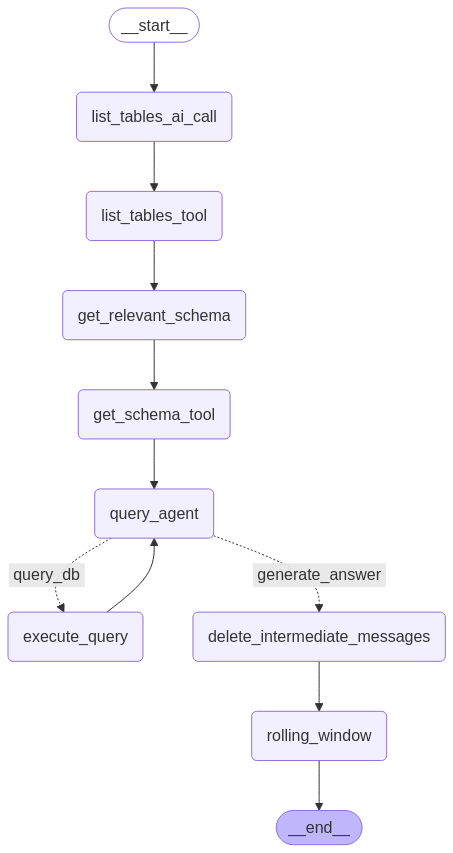

In [17]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        sql_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Streaming tokens

We often want to stream more than graph state. With chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.


## Conversation Test 1

In [18]:
import uuid

session_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": session_id}}
print(f"Session ID: {session_id}\n")

from langchain_core.messages import HumanMessage
user_input = "Hi, can you tell me the names of popular albums in the database?"

async for event in sql_graph.astream_events({"messages": [HumanMessage(content=user_input)]}, config=config, version="v2"):
    # print(f"Event: {event}\n\n")
    node = event['metadata'].get('langgraph_node','')
    event_type = event['event']
    event_name = event['name']
    print(f"Node: {node}. Type: {event_type}. Name: {event_name}")   

Session ID: 6393a2e5-e3bb-4446-85b2-95522acb11f5

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_stream. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: list_tables_ai_call. Type: on_chain_start. Name: list_tables_ai_call
Node: list_tables_ai_call. Type: on_chain_start. Name: _write
Node: list_tables_ai_call. Type: on_chain_end. Name: _write
Node: list_tables_ai_call. Type: on_chain_stream. Name: list_tables_ai_call
Node: list_tables_ai_call. Type: on_chain_end. Name: list_tables_ai_call
Node: . Type: on_chain_stream. Name: LangGraph
Node: list_tables_tool. Type: on_chain_start. Name: list_tables_tool
Node: list_tables_tool. Type: on_chain_start. Name: RunnableWithFallbacks


In [19]:
import uuid

session_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": session_id}}
print(f"Session ID: {session_id}\n")

from langchain_core.messages import HumanMessage
user_input = "Hi, can you tell me the names of popular albums in the database?"

node_to_stream = "query_agent"
async for event in sql_graph.astream_events({"messages": [HumanMessage(content=user_input)]}, config=config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        print(event["data"])    

Session ID: 5af1e652-6e8b-4179-b437-6b9c461f7098

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-0a500a73-759a-42c5-b74d-ebbe6259b6ab')}
{'chunk': AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_m5y7NhOqWzzEIJkNRjYlfK7w', 'function': {'arguments': '', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={}, id='run-0a500a73-759a-42c5-b74d-ebbe6259b6ab', tool_calls=[{'name': 'db_query_tool', 'args': {}, 'id': 'call_m5y7NhOqWzzEIJkNRjYlfK7w', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'db_query_tool', 'args': '', 'id': 'call_m5y7NhOqWzzEIJkNRjYlfK7w', 'index': 0, 'type': 'tool_call_chunk'}])}
{'chunk': AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': None, 'function': {'arguments': '{"', 'name': None}, 'type': None}]}, response_metadata={}, id='run-0a500a73-759a-42c5-b74d-ebbe6259b6ab', tool_calls=[{'name': '', 'args': {}, 'id': None, 'type': 'tool_call'}], 

In [20]:
import uuid

session_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": session_id}}
print(f"Session ID: {session_id}\n")

from langchain_core.messages import HumanMessage
user_input = "Hi, can you tell me the names of popular albums in the database?"

node_to_stream = "query_agent"
async for event in sql_graph.astream_events({"messages": [HumanMessage(content=user_input)]}, config=config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        data = event["data"]
        chunk = data["chunk"].content
        print(chunk, end="")
          

Session ID: 2120b36f-2b28-47e8-a8f8-491cd3de804f

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Title FROM Album ORDER BY AlbumId DESC LIMIT 50'}, 'id': 'call_09coIZ8K3MjJBZ69sFtXkAkr', 'type': 'tool_call'}
Here are some popular album titles from the database:

1. Koyaanisqatsi (Soundtrack from the Motion Picture)
2. Mozart: Chamber Music
3. Monteverdi: L'Orfeo
4. Schubert: The Late String Quartets & String Quintet (3 CDs)
5. Respighi: Pines of Rome
6. Locatelli: Concertos for Violin, Strings and Continuo, Vol. 3
7. Great Recordings of the Century - Shubert: Schwanengesang, 4 Lieder
8. Liszt - 12 Études D'Execution Transcendante
9. Great Recordings of the Century: Paganini's 24 Caprices
10. Nielsen: The Six Symphonies

If you need more information or additional titles, feel free to ask!

In [22]:

user_input = "Find albums released by artists who have more than 5 albums"

async for event in sql_graph.astream_events({"messages": [HumanMessage(content=user_input)]}, config=config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        data = event["data"]
        chunk = data["chunk"].content
        print(chunk, end="")

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Album.Title, Artist.Name FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.ArtistId IN (SELECT ArtistId FROM Album GROUP BY ArtistId HAVING COUNT(AlbumId) > 5) ORDER BY Artist.Name, Album.Title LIMIT 50'}, 'id': 'call_PyCqaqJyOw3RPNNPL1wFvPSx', 'type': 'tool_call'}
Here are some albums released by artists who have more than 5 albums:

**Deep Purple:**
- Come Taste The Band
- Deep Purple In Rock
- Fireball
- Knocking at Your Back Door: The Best Of Deep Purple in the 80's
- MK III The Final Concerts [Disc 1]
- Machine Head
- Purpendicular
- Slaves And Masters
- Stormbringer
- The Battle Rages On
- The Final Concerts (Disc 2)

**Iron Maiden:**
- A Matter of Life and Death
- A Real Dead One
- A Real Live One
- Brave New World
- Dance Of Death
- Fear Of The Dark
- Iron Maiden
- Killers
- Live After Death
- Live At Donington 1992 (Disc 1)
- Live At Donington 1992 (Disc 2)
- No Prayer For The Dying
- Piece Of M